In [1]:
import os
import sys
root = os.path.split(os.getcwd())[0]
if root not in sys.path:
    sys.path.append(root)
!{sys.executable} -m pip install numpy pandas intervaltree matplotlib



You should consider upgrading via the '/Users/alex/dev/mellow-strategy-sdk/examples/.exenv/bin/python3.9 -m pip install --upgrade pip' command.


In [118]:
from data import RawData, Pool
raw = RawData(Pool.USDTUSDC)

Done


sdf
0
sdf1
-6946 6937


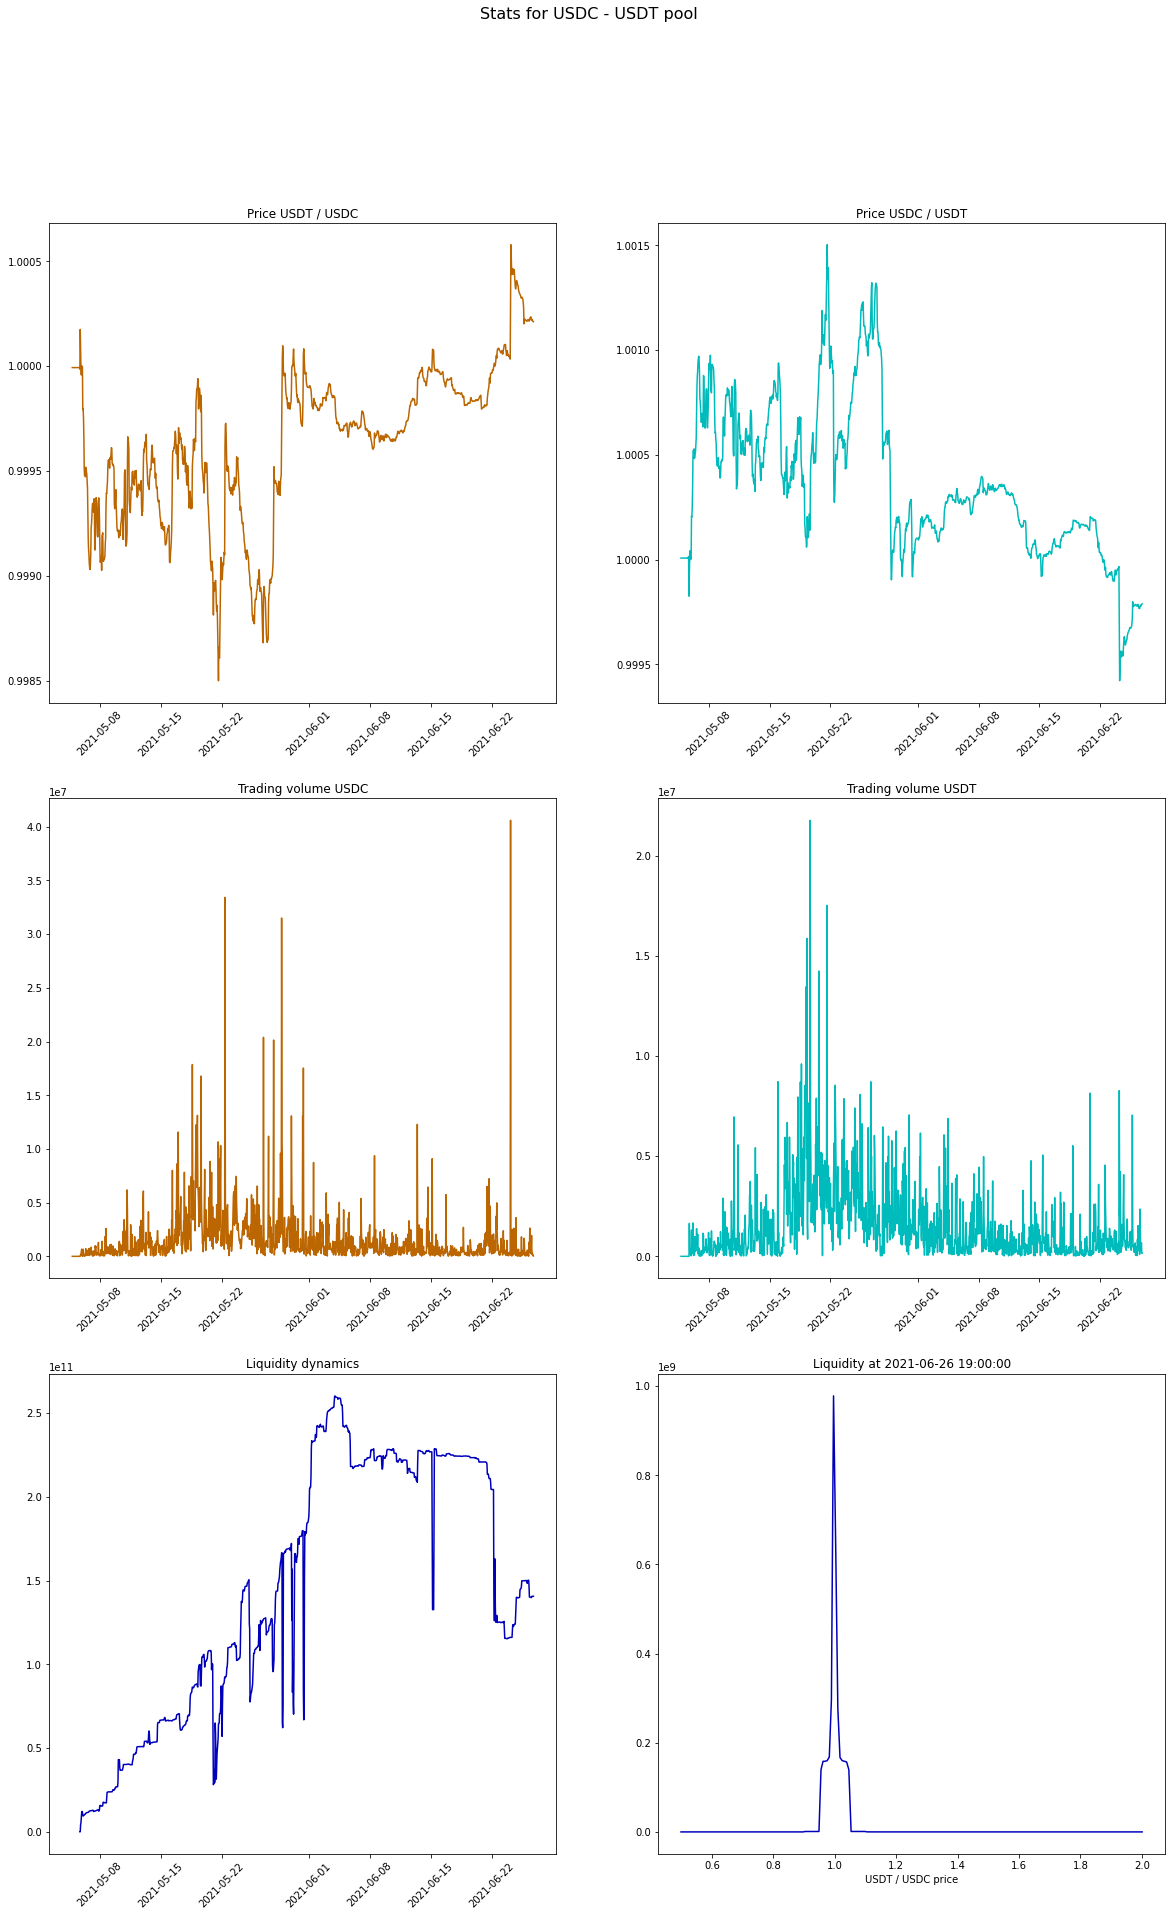

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from intervaltree import IntervalTree, Interval
from data import RawData, Pool, Frequency
from decimal import Decimal
from datetime import datetime

class LiquidityDistribution:
    def __init__(self):
        self._mints = IntervalTree()
        self._burns = IntervalTree()
    
    def append(self, mints: pd.DataFrame, burns: pd.DataFrame):
        self._mints.update([Interval(mint['tick_lower'], mint['tick_upper'], int(mint['amount'])) for idx, mint in mints.iterrows()]) 
        self._burns.update([Interval(burn['tick_lower'], burn['tick_upper'], int(burn['amount'])) for idx, burn in burns.iterrows()]) 
    
    def at(self, tick: float):
        mint = 0
        [mint := mint + interval.data for interval in self._mints[tick]]
        burn = 0
        [burn := burn + interval.data for interval in self._burns[tick]]
        return mint - burn

class Token:
    def __init__(self, name: str, decimals: int):
        self._name = name
        self._decimals = decimals

    def name(self) -> str:
        return self._name

    def decimals(self) -> int:
        return self._decimals

class PoolData:
    def __init__(self, raw_data: RawData, token0: Token, token1: Token, freq: Frequency):
        self._token0 = token0
        self._token1 = token1
        self._freq = freq
        self._mints = raw_data.mints
        self._burns = raw_data.burns
        df = pd.DataFrame()
        decimals_diff = self._token0.decimals() - self._token1.decimals()
        liquidity_decimals_diff = int((self._token0.decimals() + self._token1.decimals()) / 2)
        df["c"] = raw_data.swaps["sqrt_price_x96"].transform(lambda x: Decimal(x) * Decimal(x) / Decimal(2 ** 192) * Decimal(10 ** decimals_diff))
        df["c_inv"] = 1 / df["c"]
        df["vol0"] = (-raw_data.swaps["amount0"].where(raw_data.swaps["amount0"] < 0)).fillna(0).transform(lambda x: Decimal(x) / 10 ** token0.decimals())
        df["vol1"] = (-raw_data.swaps["amount1"].where(raw_data.swaps["amount1"] < 0)).fillna(0).transform(lambda x: Decimal(x) / 10 ** token1.decimals())
        df["l"] = raw_data.swaps["liquidity"].transform(lambda x: Decimal(x) / 10 ** liquidity_decimals_diff)
        self.data = pd.DataFrame()
        mean = lambda x: np.nan if len(x) == 0 else Decimal(np.mean(x))
        sum = lambda x: np.sum(x)
        self.data["c"] = df["c"].resample(freq.value).agg(mean).ffill()
        self.data["c_inv"] = 1 / self.data["c"]
        self.data["vol0"] = df["vol0"].resample(freq.value).agg(sum)
        self.data["vol1"] = df["vol1"].resample(freq.value).agg(sum)
        self.data["l"] = df["l"].resample(freq.value).agg(mean)
        
    
    def liquidity(self, t: datetime, c: float):
        res = 0
        for idx, mint in self._mints.iterrows():
            if mint["tick_lower"] <= c and mint["tick_upper"] >= c:
                res += mint["amount"]
        for idx, burn in self._burns.iterrows():
            if burn["tick_lower"] <= c and burn["tick_upper"] >= c:
                res -= burn["amount"]
        liquidity_decimals_diff = int((self._token0.decimals() + self._token1.decimals()) / 2)
        return Decimal(res) / 10 ** liquidity_decimals_diff
    
    def plot(self, sizex=20, sizey=30):
        """
        Plot tracking data

        :param sizex: `x` size of one chart
        :param sizey: `y` size of one chart
        """
        fig, axes = plt.subplots(3, 2, figsize=(sizex, sizey))
        fig.suptitle(f"Stats for {self._token0.name()} - {self._token1.name()} pool", fontsize=16)
        axes[0, 0].plot(self.data["c"], color="#bb6600")
        axes[0, 0].set_title(f"Price {self._token1.name()} / {self._token0.name()}")
        axes[0, 0].tick_params(axis='x', labelrotation=45)
        axes[0, 1].plot(self.data["c_inv"], color="#00bbbb")
        axes[0, 1].set_title(f"Price {self._token0.name()} / {self._token1.name()}")
        axes[0, 1].tick_params(axis='x', labelrotation=45)
        axes[1, 0].plot(self.data["vol0"], color="#bb6600")
        axes[1, 0].set_title(f"Trading volume {self._token0.name()}")
        axes[1, 0].tick_params(axis='x', labelrotation=45)
        axes[1, 1].plot(self.data["vol1"], color="#00bbbb")
        axes[1, 1].set_title(f"Trading volume {self._token1.name()}")
        axes[1, 1].tick_params(axis='x', labelrotation=45)
        axes[2, 0].plot(self.data["l"], color="#0000bb")
        axes[2, 0].set_title(f"Liquidity dynamics")
        axes[2, 0].tick_params(axis='x', labelrotation=45)
        
        current_liquidity = LiquidityDistribution()
        current_liquidity.append(self._mints, self._burns)

        decimals_diff = self._token0.decimals() - self._token1.decimals()
        liquidity_decimals_diff = int((self._token0.decimals() + self._token1.decimals()) / 2)
        
        liq_start = int(np.log(float(self.data["c"].min() / Decimal(10 ** decimals_diff) / 2)) / np.log(1.0001))
        liq_end = int(np.log(float(self.data["c"].max() / Decimal(10 ** decimals_diff) * 2)) / np.log(1.0001))
        liq_x = np.linspace(liq_start, liq_end, 200)
        print(liq_start, liq_end)
        t = self.data.index[-1]
        axes[2, 1].plot([1.0001 ** x * 10 ** decimals_diff for x in liq_x], [current_liquidity.at(x) / 10 ** liquidity_decimals_diff for x in liq_x], color="#0000bb")
        axes[2, 1].set_title(f"Liquidity at {t}")
        axes[2, 1].set_xlabel(f"{self._token1.name()} / {self._token0.name()} price")
        
        

# raw.swaps.info()
p = PoolData(raw, Token("USDC", 6), Token("USDT", 6), Frequency.HOUR)
p.data.tail(50)
print("sdf")
print(p.liquidity(pd.to_datetime("2021-06-30 08:00:00"), 240000))
print("sdf1")
p.plot()
# raw.swaps
# display(p.data)
# display(raw.burns)
# display(raw.swaps)